# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Get and Transform Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [2]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

In [3]:
vaccinations.head(3)

,date,dosen_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_biontech_kumulativ,dosen_moderna_kumulativ,dosen_astrazeneca_kumulativ,personen_erst_kumulativ,personen_voll_kumulativ,...,indikation_medizinisch_dosen,indikation_pflegeheim_dosen,indikation_alter_erst,indikation_beruf_erst,indikation_medizinisch_erst,indikation_pflegeheim_erst,indikation_alter_voll,indikation_beruf_voll,indikation_medizinisch_voll,indikation_pflegeheim_voll
0,2020-12-27,24119,24119,23982,137,24119,0,0,23982,137,...,1305,12604,10664,8590,1305,12536,41,67,0,68
1,2020-12-28,42504,18385,18385,0,42504,0,0,42367,137,...,1991,21344,18580,15721,1991,21276,41,67,0,68
2,2020-12-29,91178,48674,48085,589,91178,0,0,90452,726,...,3107,40508,34724,40420,3107,40099,265,314,0,409


In [4]:
# Drop unnecessary columns
# No analysis of indication planned:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

In [5]:
# Convert datatype of date column
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

In [6]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              102 non-null    datetime64[ns]
 1   dosen_kumulativ                   102 non-null    int64         
 2   dosen_differenz_zum_vortag        102 non-null    int64         
 3   dosen_erst_differenz_zum_vortag   102 non-null    int64         
 4   dosen_zweit_differenz_zum_vortag  102 non-null    int64         
 5   dosen_biontech_kumulativ          102 non-null    int64         
 6   dosen_moderna_kumulativ           102 non-null    int64         
 7   dosen_astrazeneca_kumulativ       102 non-null    int64         
 8   personen_erst_kumulativ           102 non-null    int64         
 9   personen_voll_kumulativ           102 non-null    int64         
 10  impf_quote_erst                   102 non-null    

## Doses per Day

In [7]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
doses.set_index('date', inplace=True)
doses.tail(3)

,dosen_differenz_zum_vortag
date,
2021-04-05,247919
2021-04-06,366566
2021-04-07,656357


<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

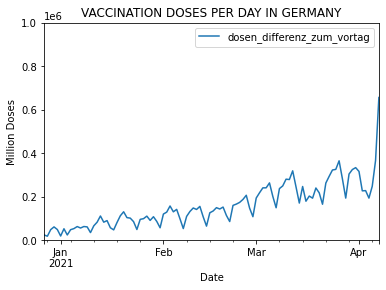

In [8]:
doses.plot(
    ylim=(0,10**6),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

## Vaccination Campaign Progress

In [9]:
doses_cumulative = vaccinations.loc[ : , ['date', 'personen_erst_kumulativ', 'personen_voll_kumulativ']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.head(3)

,personen_erst_kumulativ,personen_voll_kumulativ
date,,
2020-12-27,23982,137
2020-12-28,42367,137
2020-12-29,90452,726


In [10]:
population_germany = 83_200_000
# Calculate new fields
doses_cumulative['first vaccination'] = round(
    doses_cumulative['personen_erst_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative['fully vaccinated'] = round(
    doses_cumulative['personen_voll_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative.drop(columns=['personen_erst_kumulativ','personen_voll_kumulativ'], inplace=True)
doses_cumulative.tail(3)

,first vaccination,fully vaccinated
date,,
2021-04-05,12.84,5.47
2021-04-06,13.16,5.58
2021-04-07,13.84,5.69


<AxesSubplot:title={'center':'Vaccination Progress Germany'}, xlabel='Date', ylabel='Percentage of Population in Germany'>

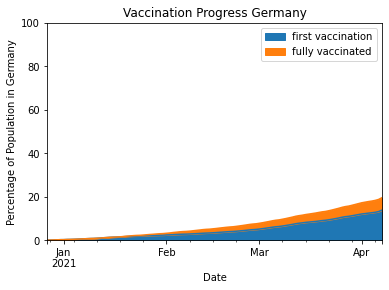

In [11]:
doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of Population in Germany',
    title='Vaccination Progress Germany')

### As of Today

In [12]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state


first vaccination    13.84
fully vaccinated      5.69
Name: 2021-04-07 00:00:00, dtype: float64

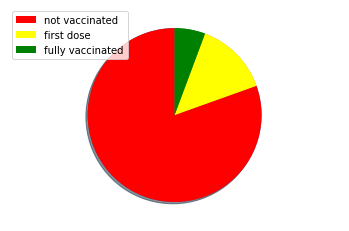

In [13]:
labels = 'not vaccinated', 'first dose', 'fully vaccinated'
colors = ['red', 'yellow', 'green']
sizes = [100 - current_state['first vaccination'] - current_state['fully vaccinated'],
         current_state['first vaccination'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.show()

## Vaccines in Use

In [14]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ', 'dosen_moderna_kumulativ', 'dosen_astrazeneca_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'Biontech', 'Moderna', 'AstraZeneca']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
vaccine_use.tail(3)

,Biontech,Moderna,AstraZeneca
date,,,
2021-04-05,11256746,789862,3184010
2021-04-06,11506821,820256,3270107
2021-04-07,12037519,848894,3367128


In [15]:
# To get the maximum for the y axis, round the highest
# number of doses up to the next million
import math
max_doses = math.ceil(max(vaccine_use.iloc[-1]) / 10**6) * 10**6
max_doses

13000000

<AxesSubplot:title={'center':'VACCINES USED IN GERMANY'}, xlabel='Date', ylabel='Doses cumulative'>

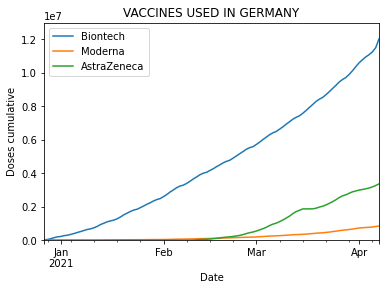

In [16]:
vaccine_use.plot(
    ylim=(0,max_doses),
    xlabel='Date',
    ylabel='Doses cumulative',
    title='VACCINES USED IN GERMANY')